# Speed Dating Analysis Report
<img src="https://images.seattletimes.com/wp-content/uploads/2018/12/speeddating-1205-RGB-1.jpg?d=1200x630" width = "600"/>

Source: https://www.seattletimes.com/life/lifestyle/speed-dating-in-the-age-of-swiping-the-irl-dating-trend-is-still-ringing-bells/

#### Can we predict whether two heterosexual people matched or not based on 6 attributes after 4 minutes of speed dating? 

### Introduction:
"Speed dating" is a matchmaking process that involves two people getting to know one another within a very short time frame (usually less than 10 minutes), and then switching to another person once the time is up. This speedy and energetic approach to meeting other single people may result in a match between two individuals where they both choose to pursue dating. But what factors influence whether or not two people match? <b> Is there a way to predict whether two people will match or not in a speed date based on certain attributes? </b> 
The Speed Dating dataset posted by Ulrik Thyge Pedersen gathered data from participants in a four-minute speed dating experiment where they were asked to rate their date on six different attributes: attractiveness, sincerity, intelligence, humour, ambition, and shared interests. Using this data, we will attempt to predict whether or not two people will match based on these attributes.

In [1]:
#Run this cell to import program
import altair as alt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split

#### Speed Dating Dataframe

To begin, we read in the raw data.

In [2]:
df_speeddating = pd.read_csv("speeddating.csv")

df_speeddating.head(5)

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',...,b'[0-3]',b'[3-5]',7.0,NaN,b'[6-8]',b'[0-4]',1.0,b'1',b'1',b'1'
3,b'',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'
4,b'',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',...,b'[0-3]',b'[3-5]',6.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'


#### Cleaning and wrangling data
Next, we shall make our speed dating data suitable for our analysis. First, we extract the six attributes (attractive_partner, sincere_partner, intelligence_partner, humour_partner, ambition_partner, shared_interests_partner) columns and the class column (match) that are required for this analysis using square brackets. Then, by using .dropna(), we remove the rows that contain NULL value, "NaN". We will also rename the values of the class column "match" from b'0' to "fail" and b'1' to "success". Moreover, we must convert the "match" column stored as an object type to a categorical type. 


In [45]:
speeddating = df_speeddating[["match","attractive_partner", "sincere_partner","intelligence_partner", "funny_partner", "ambition_partner", "shared_interests_partner"]]

speeddating = speeddating.sample(n=1000, random_state=2023).dropna()

speeddating = speeddating.rename(columns={"funny_partner":"humour_partner"})

speeddating["match"] = speeddating["match"].replace({"b'0'":"fail","b'1'":"success"}).astype("category")
speeddating.head(5)

,match,attractive_partner,sincere_partner,intelligence_partner,humour_partner,ambition_partner,shared_interests_partner
3852,fail,9.0,8.0,8.0,8.0,6.0,2.0
1938,fail,5.0,5.0,6.0,6.0,5.0,5.0
4879,fail,7.0,5.0,6.0,4.0,5.0,5.0
1619,fail,7.0,10.0,8.0,7.0,7.0,3.0
3151,fail,7.0,6.0,7.0,6.0,6.0,5.0


#### Summary of Speeddating Data
With seven columns, one category type, and six numeric types, we can see that our data is now organised and prepared to be divided into train and test sets using the info function. 

In [46]:
speeddating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 3852 to 58
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   match                     826 non-null    category
 1   attractive_partner        826 non-null    float64 
 2   sincere_partner           826 non-null    float64 
 3   intelligence_partner      826 non-null    float64 
 4   humour_partner            826 non-null    float64 
 5   ambition_partner          826 non-null    float64 
 6   shared_interests_partner  826 non-null    float64 
dtypes: category(1), float64(6)
memory usage: 46.1 KB


#### Creating the training and test sets
Next, we will split the cleaned speed-dating data into a training and testing set. We will then use the training set to perform an exploratory analysis on the six variables and to explore the dataset. After making the classifier to predict the "match" of speed-dating with training set, we use the test set to evaluate the accuracy of the model to predict the "match" on new observation. 


To preserve the higher proportions of "fail" categories, we used the parameter "stratitfy" in the train_test_split, which ensures the same proportions of "success" and "fail" categories are split into the training and testing sets, which decreases bias.

In [47]:
speeddating_train, speeddating_test = train_test_split(
   speeddating, train_size=0.75, random_state=2023, stratify=speeddating["match"] # do not change the random_state
)
speeddating_train = pd.DataFrame(speeddating_train)
speeddating_train.head(5)

,match,attractive_partner,sincere_partner,intelligence_partner,humour_partner,ambition_partner,shared_interests_partner
8042,fail,5.0,8.0,7.0,8.0,5.0,4.0
6043,fail,9.5,7.0,7.0,8.0,9.0,6.0
1340,fail,6.0,7.0,6.0,6.0,6.0,5.0
3089,fail,6.0,7.0,7.0,5.0,6.0,6.0
7741,success,3.0,9.0,9.0,5.0,7.0,3.0


#### Checking the "match" data distribution

In [40]:
speeddating_train_dd = speeddating_train.assign(row_number=range(len(speeddating_train)))

explore_speeddating = pd.DataFrame()

explore_speeddating['count'] = speeddating_train_dd.groupby('match')['row_number'].count()
explore_speeddating['percentage'] = 100 * explore_speeddating['count']/len(speeddating_train_dd)

explore_speeddating

,count,percentage
match,,
fail,507,81.9063
success,112,18.0937


We can see from this table that there is an imbalance in the match class; where 83.0% failed to match and 18.2% was successful. This would be a limitation for our model and its accuracy. Since 83.0% of speed dates failed, our model may have a high accuracy (around 80 percent) because it will correctly predict a lot of failed dates but it will not be very accurate in predicting successful dates.

#### Creating Boxplots 
The distribution of attribute ratings may be viewed using a box plot, which also makes it possible to compare and contrast match outcomes. To determine the impact of each property on the match outcomes, we produced six boxplots for each attribute using seaborn.boxplot.

[Text(0.5, 1.0, 'Figure 1: Comparison of match results for Attraction Attribute'),
 Text(0, 0.5, "Rating of Partner's Attractiveness"),
 Text(0.5, 0, 'Match')]

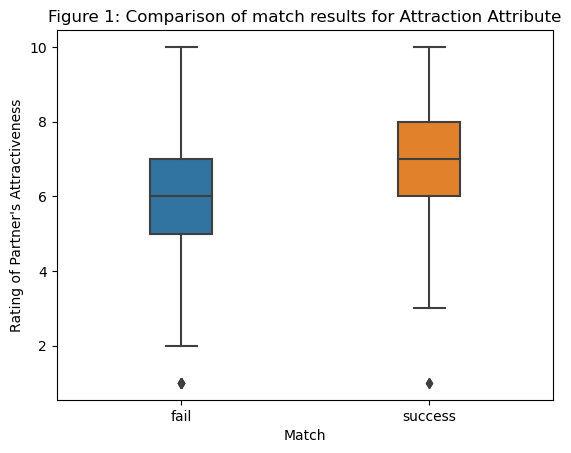

In [48]:
# Boxplot1
sns.boxplot(x='match', y='attractive_partner', width=0.25, data=speeddating_train).set(title='Figure 1: Comparison of match results for Attraction Attribute', ylabel="Rating of Partner's Attractiveness", xlabel="Match")

Interpretation of Figure 1: This boxplot compares the explanatory variable "Partner's Attractiveness", and the response variable of "match outcome". The median shows that on average a partner's attractiveness score was one rating higher for successful matches than failed matches. 

[Text(0.5, 1.0, 'Figure 2: Comparison of match results for Sincere Attribute'),
 Text(0, 0.5, "Rating of Partner's Sincerity"),
 Text(0.5, 0, 'Match')]

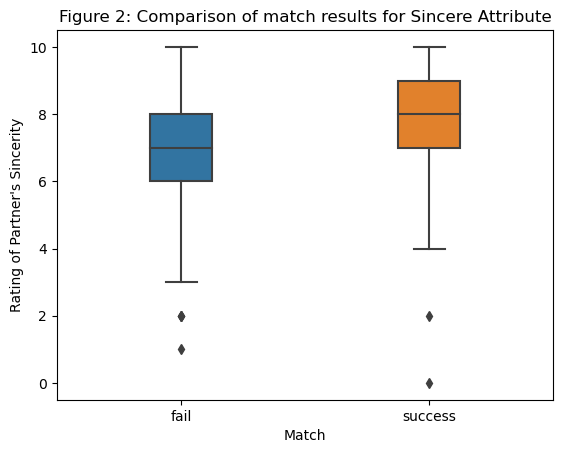

In [8]:
# BoxPlot2 
sns.boxplot(x='match', y='sincere_partner', width=0.25, data=speeddating_train).set(title='Figure 2: Comparison of match results for Sincere Attribute', ylabel="Rating of Partner's Sincerity", xlabel="Match")

Interpretation of Figure 2: This boxplot compares the explanatory variable "Partner's Sincerity", and the response variable of "match outcome". The median shows that on average a partner's sincerity score was one rating higher for successful matches than failed matches. Both categories of “match” have two outlier points. 

[Text(0.5, 1.0, 'Figure 3: Comparison of match results for Intelligence Attribute'),
 Text(0, 0.5, "Rating of Partner's Intelligence"),
 Text(0.5, 0, 'Match')]

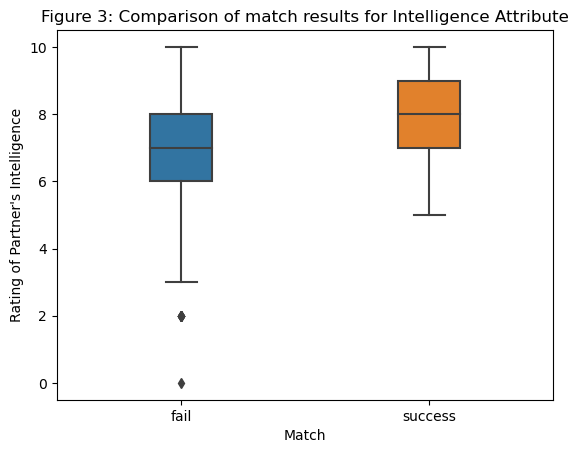

In [9]:
# Boxplot3
sns.boxplot(x='match', y='intelligence_partner', width=0.25, data=speeddating_train).set(title='Figure 3: Comparison of match results for Intelligence Attribute', ylabel="Rating of Partner's Intelligence", xlabel="Match")

Interpretation of Figure 3: The explanatory variable "Partner's Intelligence" and the response variable "match outcome" are compared in this boxplot. The median pattern is the same as in Figure 1 and Figure 2. However, the range of category “success” is relatively small, which means partners that were rated below five were never successful in matching.  

[Text(0.5, 1.0, 'Figure 4: Comparison of match results for Humour Attribute'),
 Text(0, 0.5, "Rating of Partner's Humour"),
 Text(0.5, 0, 'Match')]

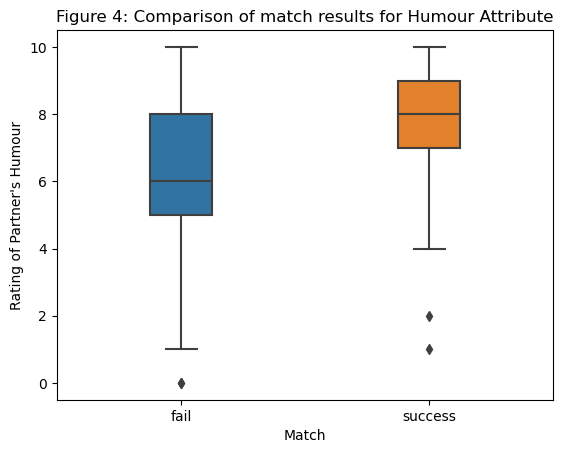

In [68]:
# Boxplot 4
sns.boxplot(x='match', y='humour_partner', width=0.25, data=speeddating_train).set(title='Figure 4: Comparison of match results for Humour Attribute', ylabel="Rating of Partner's Humour", xlabel="Match")

Interpretation of Figure 4: The explanatory variable of "Partner’s Humour" and the response variable "match outcome" are compared in this boxplot. The median shows that on average a partner's humour score was two ratings higher for successful matches than failed matches. Moreover, non-overlapping boxes are shown meaning there exists a difference between the category “success” and the category “fail.”

[Text(0.5, 1.0, 'Figure 5: Comparison of match results for Ambition Attribute'),
 Text(0, 0.5, "Rating of Partner's Ambition"),
 Text(0.5, 0, 'Match')]

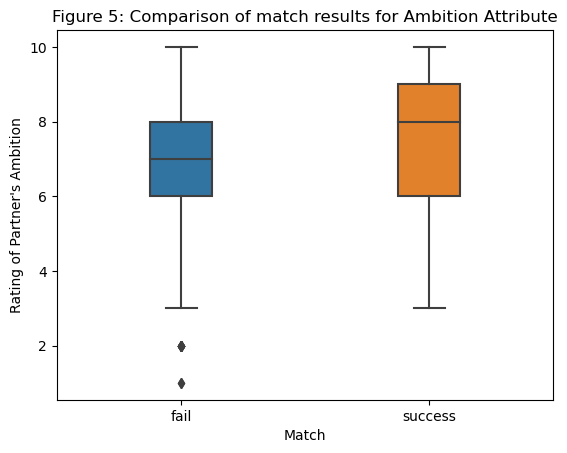

In [66]:
# Boxplot 5
sns.boxplot(x='match', y='ambition_partner', width=0.25, data=speeddating_train).set(title='Figure 5: Comparison of match results for Ambition Attribute', ylabel="Rating of Partner's Ambition", xlabel="Match")

Interpretation of Figure 5: The explanatory variable of "Partner’s Ambition" and the response variable "match outcome" are compared in this boxplot. There exists a relatively large overlap between the boxplots here, meaning the rating does not impact the match as it could either fail or succeed. The rating does not seem to influence the outcome of the match. 

[Text(0.5, 1.0, 'Figure 6: Comparison of match results for Shared Interests Attribute'),
 Text(0, 0.5, "Rating of Partner's Shared Interests"),
 Text(0.5, 0, 'Match')]

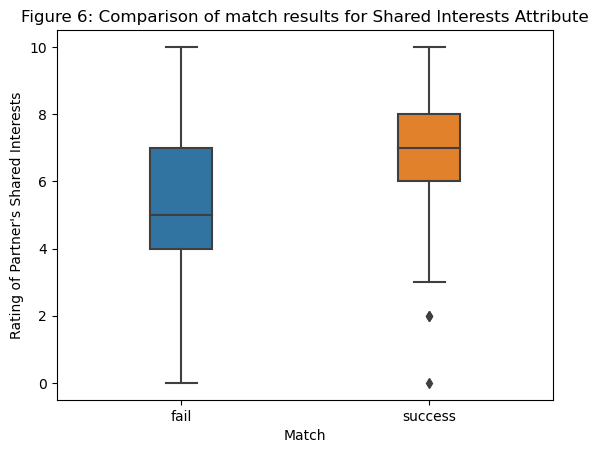

In [67]:
# Boxplot6
sns.boxplot(x='match', y='shared_interests_partner', width=0.25, data=speeddating_train).set(title='Figure 6: Comparison of match results for Shared Interests Attribute', ylabel="Rating of Partner's Shared Interests", xlabel="Match")

Interpretation of Figure 6: The explanatory variable of "Partner’s Shared Interest" and the response variable "match outcome" are compared in this boxplot. The median shows that on average a partner's shared interest score was two ratings higher for successful matches than failed matches. However, there are two outliers in the category of “success.”

We have investigated how each attribute of the participants relates with their success or failure in speed dating. Yet, because a person might have a mix of qualities, these boxplots are insufficient for us to draw a conclusion regarding the predictors. We thus made the decision to make several combinations of the attributes, apply hyperparameter optimization to determine the most accurate k-value and obtain the accuracy through cross-validation. Finally,  we utilize the combination that is best for our model.

To guarantee that we develop the model with the best level of accuracy feasible and that our model is neither overfit nor underfit, it is crucial to optimise the hyperparameter K in KNN classification. 

#### Combination 1: Attractiveness, Intelligence, Humour, Sincerity

In [32]:
# first combination: attractive, intelligence, Humour, sincere
np.random.seed(1000)
speeddating_train, speeddating_test = train_test_split(speeddating, test_size=0.25, random_state=123)
# preprocess data
speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), ["attractive_partner", "intelligence_partner", 
                        "humour_partner", "sincere_partner"])
)

# make a dataframe for finding the highest accuracy
# accuracies grid
knn = KNeighborsClassifier()
speeddating_tune_pipe = make_pipeline(speeddating_preprocessor, knn)


parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}

speeddating_tune_grid = GridSearchCV(
    estimator=speeddating_tune_pipe,
    param_grid=parameter_grid,
    cv=10
)

accuracies_grid = pd.DataFrame(
             speeddating_tune_grid
             .fit(speeddating_train.loc[:, ["attractive_partner", "intelligence_partner",
                                            "humour_partner", "sincere_partner"]],
                  speeddating_train["match"]
            ).cv_results_)


accuracies_grid = accuracies_grid[["param_kneighborsclassifier__n_neighbors", 
                                   "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )
accuracies_grid.sort_values(by="mean_test_score",ascending=False).head(5)

,n_neighbors,mean_test_score,sem_test_score
6,31,0.820703,0.008620
5,26,0.820677,0.008047
3,16,0.817478,0.008489
16,81,0.817451,0.002293
10,51,0.814225,0.004064


After splitting the training data into another subtraining and validation sets, a preprocessor was made and GridSearchCV was used to tune the data.

Using the tuned grid, an accuracies grid was made with the columns for the k value ordered in descending order in terms of mean test score. The k value with the highest accuracy is 16 for the first combination.

In [14]:
np.random.seed(1000)
# now use k=31 to tune data and test accuracy of model
# use a split of the training set for validation set
# create the 25/75 split of the *training data* into sub-training and validation
speeddating_subtrain, speeddating_validation = train_test_split(
    speeddating_train, test_size=0.25
)


# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=16) 
X = speeddating_subtrain.loc[:, ["attractive_partner","intelligence_partner",
                                 "humour_partner", "sincere_partner"]]
y = speeddating_subtrain["match"]
knn_fit = make_pipeline(speeddating_preprocessor, knn).fit(X, y)

# compute the score on validation data
acc = knn_fit.score(
    speeddating_validation.loc[:, ["attractive_partner","intelligence_partner",
                                   "humour_partner", "sincere_partner"]],
    speeddating_validation["match"]
)
acc

0.8064516129032258

We get an accuracy score of 0.806 which is not a low score, but we will try other combinations of predictors to see if they have a higher accuracy score.

#### Combination 2: Sincere, Intelligence, Shared Interests, Ambition 

In [15]:
# second combination: sincere, intelligence, shared interests, ambition 
np.random.seed(1000)
speeddating_train, speeddating_test = train_test_split(speeddating, test_size=0.25, random_state=123)
# preprocess data
speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), ["sincere_partner","intelligence_partner",
                        "shared_interests_partner", "ambition_partner"])
)

# make a dataframe for finding the highest accuracy
# accuracies grid
knn = KNeighborsClassifier()
speeddating_tune_pipe = make_pipeline(speeddating_preprocessor, knn)


parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}

speeddating_tune_grid = GridSearchCV(
    estimator=speeddating_tune_pipe,
    param_grid=parameter_grid,
    cv=10
)

accuracies_grid = pd.DataFrame(
             speeddating_tune_grid
             .fit(speeddating_train.loc[:, ["sincere_partner","intelligence_partner",
                                            "shared_interests_partner", "ambition_partner"]],
                  speeddating_train["match"]
            ).cv_results_)


accuracies_grid = accuracies_grid[["param_kneighborsclassifier__n_neighbors", 
                                   "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )
accuracies_grid.sort_values(by="mean_test_score",ascending=False).head(5)

,n_neighbors,mean_test_score,sem_test_score
10,51,0.814252,0.003961
11,56,0.814225,0.002472
7,36,0.812586,0.008317
12,61,0.812586,0.003456
6,31,0.812559,0.009271


Our second combination of the predictors "sincere_partner", "intelligence_partner", "shared_interests_partner", and "ambition_partner" was found to have the k value of 56 for the highest accuracy. It is a rather large number compared to the previous k value of 16, but it was found to have a better accuracy than k=6 when we tune the data and test the model. 

In [16]:
np.random.seed(1000)
# k=56 has the highest accuracy
speeddating_subtrain, speeddating_validation = train_test_split(
    speeddating_train, test_size=0.25
)


# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=56) 
X = speeddating_subtrain.loc[:, ["sincere_partner","intelligence_partner",
                                 "shared_interests_partner", "ambition_partner"]]
y = speeddating_subtrain["match"]
knn_fit = make_pipeline(speeddating_preprocessor, knn).fit(X, y)

# compute the score on validation data
acc = knn_fit.score(
    speeddating_validation.loc[:, ["sincere_partner","intelligence_partner",
                                   "shared_interests_partner", "ambition_partner"]],
    speeddating_validation["match"]
)
acc

0.8129032258064516

The second combination gives us the accuracy of 0.813, which is higher than the first combination.

#### Combination 3: Attractiveness, Humour, Shared Interests, Intelligence

In [17]:
# third combination: attractiveness, humour, shared_interests, intelligence
np.random.seed(1000)
speeddating_train, speeddating_test = train_test_split(speeddating, test_size=0.25, random_state=123)
# preprocess data
speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), ["attractive_partner","intelligence_partner",
                        "humour_partner", "shared_interests_partner"])
)

# make a dataframe for finding the highest accuracy
# accuracies grid
knn = KNeighborsClassifier()
speeddating_tune_pipe = make_pipeline(speeddating_preprocessor, knn)


parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}

speeddating_tune_grid = GridSearchCV(
    estimator=speeddating_tune_pipe,
    param_grid=parameter_grid,
    cv=10
)

accuracies_grid = pd.DataFrame(
             speeddating_tune_grid
             .fit(speeddating_train.loc[:, ["attractive_partner", "intelligence_partner",
                                            "humour_partner", "shared_interests_partner"]],
                  speeddating_train["match"]
            ).cv_results_)


accuracies_grid = accuracies_grid[["param_kneighborsclassifier__n_neighbors", 
                                   "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )
accuracies_grid.sort_values(by="mean_test_score",ascending=False).head(5)

,n_neighbors,mean_test_score,sem_test_score
18,91,0.814225,0.002472
17,86,0.812586,0.002597
1,6,0.812586,0.006161
9,46,0.810999,0.004527
19,96,0.810973,0.002421


In [18]:
np.random.seed(1000)
# k=51 has the highest accuracy
speeddating_subtrain, speeddating_validation = train_test_split(
    speeddating_train, test_size=0.25
)
# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=91) 
X = speeddating_subtrain.loc[:, ["attractive_partner","intelligence_partner",
                                "humour_partner", "shared_interests_partner"]]
y = speeddating_subtrain["match"]
knn_fit = make_pipeline(speeddating_preprocessor, knn).fit(X, y)

# compute the score on validation data
acc = knn_fit.score(
    speeddating_validation.loc[:, ["attractive_partner","intelligence_partner",
                                    "humour_partner", "shared_interests_partner"]],
    speeddating_validation["match"]
)
acc

0.8129032258064516

The third combination gives us an accuracy of 0.813, which is higher than the first and same with the second combination.

#### Combination 4: Attractiveness, Intelligence, Humour, Sincere, Shared Interests

In [61]:
# fourth combination: attractiveness, intelligence, humour, sincere, shared interests
np.random.seed(1000)
speeddating_train, speeddating_test = train_test_split(speeddating, test_size=0.25, random_state=123)

# preprocess data
speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), ["attractive_partner",  "sincere_partner","intelligence_partner", 
                        "humour_partner","shared_interests_partner"])
)

# make a dataframe for finding the highest accuracy
# accuracies grid
knn = KNeighborsClassifier()
speeddating_tune_pipe = make_pipeline(speeddating_preprocessor, knn)


parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}

speeddating_tune_grid = GridSearchCV(
    estimator=speeddating_tune_pipe,
    param_grid=parameter_grid,
    cv=10
)

accuracies_grid = pd.DataFrame(
             speeddating_tune_grid
             .fit(speeddating_train.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                            "humour_partner","shared_interests_partner"]],
                  speeddating_train["match"]
            ).cv_results_)


accuracies_grid = accuracies_grid[["param_kneighborsclassifier__n_neighbors", 
                                   "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )
accuracies_grid.sort_values(by="mean_test_score",ascending=False).head(5)

,n_neighbors,mean_test_score,sem_test_score
4,21,0.819117,0.009261
1,6,0.819064,0.005939
5,26,0.814252,0.008540
12,61,0.814199,0.004766
14,71,0.812612,0.002399


In [65]:
np.random.seed(1000)
# now use k=6 to find accuracy of model
speeddating_subtrain, speeddating_validation = train_test_split(
    speeddating_train, test_size=0.25
)
# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=6) 
X = speeddating_subtrain.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                 "humour_partner","shared_interests_partner"]]
y = speeddating_subtrain["match"]
knn_fit = make_pipeline(speeddating_preprocessor, knn).fit(X, y)

# compute the score on validation data
acc = knn_fit.score(
    speeddating_validation.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                   "humour_partner","shared_interests_partner"]],
    speeddating_validation["match"]
)
acc

0.8451612903225807

This combination of attributes now has the highest accuracy of 0.845 out of all combinations so far. 

#### Combination 5: Attractiveness, Intelligence, Humour, Sincere, Shared Interests, Ambition (all six attributes)

In [21]:
# fifth combination: attractiveness, intelligence, humour, sincere, shared interests, ambition (all six attributes)
np.random.seed(1000)
speeddating_train, speeddating_test = train_test_split(speeddating, test_size=0.25, random_state=123)
# preprocess data
speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), ["attractive_partner",  "sincere_partner","intelligence_partner", 
                        "humour_partner", "ambition_partner", "shared_interests_partner"])
)

# make a dataframe for finding the highest accuracy
# accuracies grid
knn = KNeighborsClassifier()
speeddating_tune_pipe = make_pipeline(speeddating_preprocessor, knn)


parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}

speeddating_tune_grid = GridSearchCV(
    estimator=speeddating_tune_pipe,
    param_grid=parameter_grid,
    cv=10
)

accuracies_grid = pd.DataFrame(
             speeddating_tune_grid
             .fit(speeddating_train.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                            "humour_partner","ambition_partner","shared_interests_partner"]],
                  speeddating_train["match"]
            ).cv_results_)


accuracies_grid = accuracies_grid[["param_kneighborsclassifier__n_neighbors", 
                                   "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )
accuracies_grid.sort_values(by="mean_test_score",ascending=False).head(5)

,n_neighbors,mean_test_score,sem_test_score
14,71,0.823903,0.007729
4,21,0.823876,0.007098
16,81,0.820703,0.006564
13,66,0.820677,0.007372
7,36,0.820650,0.007784


In [22]:
np.random.seed(1000)
# now use k=6 to find accuracy of model
speeddating_subtrain, speeddating_validation = train_test_split(
    speeddating_train, test_size=0.25
)
speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), ["attractive_partner",  "sincere_partner","intelligence_partner", 
                        "humour_partner", "shared_interests_partner"])
)
# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=71) 
X = speeddating_subtrain.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                 "humour_partner", "shared_interests_partner"]]
y = speeddating_subtrain["match"]
knn_fit = make_pipeline(speeddating_preprocessor, knn).fit(X, y)

# compute the score on validation data
acc = knn_fit.score(
    speeddating_validation.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                   "humour_partner", "shared_interests_partner"]],
    speeddating_validation["match"]
)
acc

0.8129032258064516

The final combination of all six attributes has the accuracy of 0.813.

#### Conclusion from Exploratory Data Analysis
After assessing the cross-validation accuracy estimate, we identified that Combination 4 (Attractiveness, Intelligence, Humour, Sincere, Shared Interests) with k = 6 gave us a roughly optimal accuracy of 8.45. The attribute that is not included in this combination 4 is "Ambition", and refering back to Figure 5, the Boxplot of the Comparison of match results for Ambition Attribute shows great overlap of boxes. So ambition rating does not have a great influence on the speed-dating match outcomes.

#### Confusion Matrix with Combination 4

With our speeddating_train, we will now generate a confusion matrix for the classifier, which will show us how many observations of each label were properly and incorrectly identified.

Text(0.5, 1.0, 'Figure 7: Confusion Matrix of Combination 4')

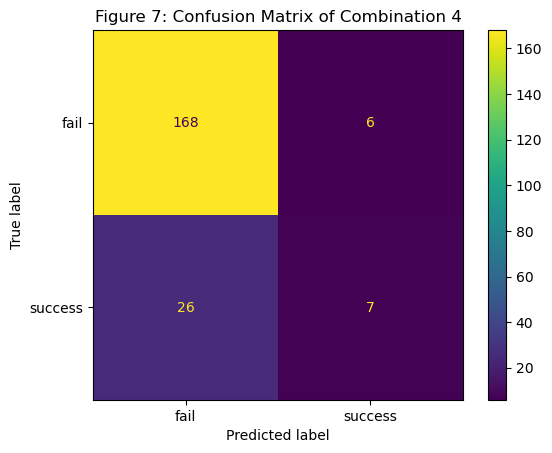

In [71]:
# confusion matrix with selected variables
# speeddating_train, speeddating_test = train_test_split(speeddating, test_size=0.25, random_state=123) # set the random state to be 123
np.random.seed(1000)

speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), [
        "attractive_partner", "sincere_partner","intelligence_partner","humour_partner","shared_interests_partner"]),
)

knn_spec = KNeighborsClassifier(n_neighbors=6)

X = speeddating_train[[
    "attractive_partner", "sincere_partner","intelligence_partner","humour_partner","shared_interests_partner"]]
y = speeddating_train["match"]

speeddating_fit = make_pipeline(speeddating_preprocessor, knn_spec).fit(X, y)

speeddating_test_predictions = speeddating_fit.predict(speeddating_test)
speeddating_test_predictions = pd.concat(
    [
        speeddating_test.reset_index(drop=True),
        pd.DataFrame(speeddating_test_predictions, columns=["predicted"]),
    ],
    axis=1,
)

speeddating_test_predictions


speeddating_mat = sklearn.metrics.confusion_matrix(
    speeddating_test_predictions["match"],
    speeddating_test_predictions["predicted"],
    labels=speeddating_fit.classes_,
)

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=speeddating_mat, display_labels=speeddating_fit.classes_
)
disp.plot()
disp.ax_.set_title("Figure 7: Confusion Matrix of Combination 4")

Out of the total 207 samples, 7 were correctly classfied as "success" and 168 samples were correctly classified as "fail". Therefore, the overall accuracy of the classifier on the test set is about 85%. The classifier mistook 26 observation as fail, and mistook 6 observation as success.

#### Using the model on the test set

In [72]:
np.random.seed(1000)

speeddating_preprocessor = make_column_transformer(
    (StandardScaler(), [
        "attractive_partner", "sincere_partner","intelligence_partner","humour_partner","ambition_partner","shared_interests_partner"]),
)

knn_spec = KNeighborsClassifier(n_neighbors=6)

# fit the model on the sub-training data
X = speeddating_test.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                 "humour_partner","ambition_partner","shared_interests_partner"]]
y = speeddating_test["match"]
knn_fit = make_pipeline(speeddating_preprocessor, knn_spec).fit(X, y)

# compute the score on validation data
acc = knn_fit.score(
    speeddating_validation.loc[:, ["attractive_partner",  "sincere_partner","intelligence_partner", 
                                   "humour_partner", "ambition_partner","shared_interests_partner"]],
    speeddating_validation["match"]
)
acc

0.8193548387096774

So the accuracy on the test set of our model is 82%, and from the confusion matrix we obtained overall accuracy of 85%. 

## Discussion

#### Summary of results:
Since the majority of the training data belongs to the fail class, the majority classifier will always forecast that a new observation would result in a fail match. The accuracy of our K-nearest neighbours classifier was 82%, and according to our critical analysis/ confusion matrix, this classifier has a greater predictability of 85%. Therefore, we think the classifier's performance is adequate for the application. But this can be made better...  

#### Expectations and impacts of results:

These results were what we expected to find. The research that we found showed that attractiveness was an important aspect of attraction on a speed date, which showed in our results. Our results also showed that it’s difficult to successfully predict when two people will match based on attributes, which was also expected because relationships and interactions between people are very complicated in real life, and rely on many more factors than just six (for example, body language, what mood someone is in, the atmosphere of the date, and many, many more). These findings could encourage further research into the different individual attributes that affect relationships between people in settings like speed dating. These findings could also encourage more experienced data analyzers to build a model with an even higher accuracy for this dataset or datasets similar to form a clearer relationship between individual attributes and whether two people match. Another impact of our findings could be to bring attention to which attributes are favoured when individuals are seeking romantic partners. 

#### Future questions

These findings could lead to future questions as well, for example, are there more variables or traits that can affect whether two people match or not on a speed date? Are certain types of people more likely to favour particular traits over others? Do external factors of a speed date also affect whether or not two people match (for example, the location, lighting, or speed of the date)? 

### Sources/ Citation 

Shanhong, L., Guangjian, Z. (2009). What Leads to Romantic Attraction: Similarity, Reciprocity, Security, or Beauty? Evidence From a Speed-Dating Study. Journal of Personality, 77, 933-964. https://onlinelibrary.wiley.com/doi/full/10.1111/j.1467-6494.2009.00570.x

Priyadarshini, T. S. (2018). Machine Learning Approaches To Identify Preferences In An Ideal Match Using Speed Dating Data [MSc Research Project, National College of Ireland]. https://norma.ncirl.ie/3417/1/priyadarshinitarikereshivaprasad.pdf 